In [ ]:
# https://paperswithcode.com/paper/lets-keep-it-simple-using-simple

In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor

# Load datasets

In [4]:
# Initialize label encoder
label_encoder = LabelEncoder()

def load_image(image_path):
    """
    Load an image from the given path.
    """
    # Using cv2 for potentially faster image loading
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_images_and_labels(base_dir, data_type, label_file, is_train=True, num_workers=16):
    """
    Load images and corresponding labels from specified directory and label file using multithreading.
    If is_train is True, fit the label encoder on labels.
    """
    labels_df = pd.read_csv(os.path.join(base_dir, label_file))
    if is_train:
        # Fit label encoder and transform labels to integers if training
        labels_df['label'] = label_encoder.fit_transform(labels_df['label'])
        
        # Saving the fitted LabelEncoder to disk for later use
        with open('label_encoder.pkl', 'wb') as file:
            pickle.dump(label_encoder, file)
    else:
        # Transform labels to integers using already fitted encoder if testing
        labels_df['label'] = label_encoder.transform(labels_df['label'])
        
    num_images = len(labels_df)
    images = np.empty((num_images, 32, 32, 3), dtype=np.uint8)
    labels = np.empty((num_images, 1), dtype=int)
    image_ids = labels_df['id'].values  # Save IDs for reference

    def process_row(idx):
        row = labels_df.iloc[idx]
        image_id = str(row['id'])
        image_folder = os.path.join(base_dir, data_type, 'test' if 'testLabels.csv' in label_file else 'train')
        image_path = os.path.join(image_folder, image_id + '.png')
        images[idx] = load_image(image_path)
        labels[idx] = row['label']
    
    # Use ThreadPoolExecutor to load images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(process_row, range(num_images))

    return images, labels, image_ids

# Define the base directory where your train and test folders and label files are stored
base_dir = './data/'

# Load training and testing data
X_train, y_train, train_ids = load_images_and_labels(base_dir, 'train', 'trainLabels.csv', is_train=True)
X_test, y_test, test_ids = load_images_and_labels(base_dir, 'test', 'testLabels.csv', is_train=False)

print("Train shape: X_train = " + str(X_train.shape) + ", y_train = " + str(y_train.shape))
print("Test shape: X_test = " + str(X_test.shape) + ", y_test = " + str(y_test.shape))

Train shape: X_train = (50000, 32, 32, 3), y_train = (50000, 1)
Test shape: X_test = (10000, 32, 32, 3), y_test = (10000, 1)


In [5]:
# Flatten the array to make it one-dimensional if it's not already
y_test_flat = y_train.flatten()

# Use numpy.unique to get the unique values and their counts
unique_values, counts = np.unique(y_test_flat, return_counts=True)

# Create a dictionary to see the count of each unique value
value_counts = dict(zip(unique_values, counts))

print(value_counts)

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


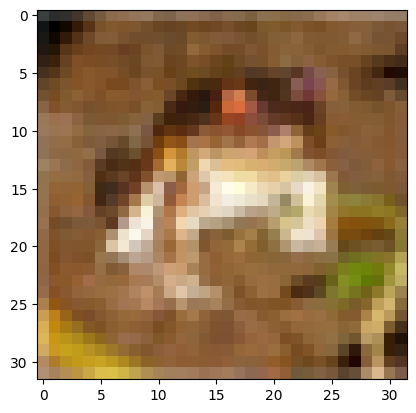

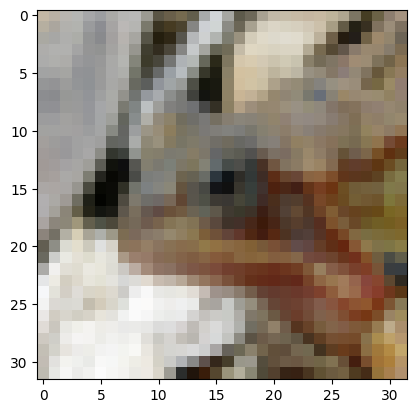

In [6]:
# Show some samples in the dataset
import matplotlib.pyplot as plt
imgplot = plt.imshow(X_train[0])
plt.show()
imgplot = plt.imshow(X_test[10])
plt.show()

In [7]:
# Normalize pixel values
X_train, X_test = X_train/255.0, X_test/255.0

In [8]:
## Split train/valid from the training set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5)

print("Train shape: X_train = " + str(X_train.shape) + ", y_train = " + str(y_train.shape))
print("Val shape: X_val = " + str(X_val.shape) + ", y_val = " + str(y_val.shape))
print("Test shape: X_test = " + str(X_test.shape) + ", y_test = " + str(y_test.shape))

Train shape: X_train = (45000, 32, 32, 3), y_train = (45000, 1)
Val shape: X_val = (5000, 32, 32, 3), y_val = (5000, 1)
Test shape: X_test = (10000, 32, 32, 3), y_test = (10000, 1)


# Build model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = datagen.flow(X_train, y_train, batch_size=512)

In [10]:
# Import library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense,
    GlobalAveragePooling2D
)

import tensorflow as tf
model = Sequential([
    # Block 1
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    # Block 2
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(196, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    # Block 3
    Conv2D(196, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(196, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    # Block 4
    Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    # Block 5
    Conv2D(1024, kernel_size=(1, 1), strides=(1, 1), padding='valid'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    Conv2D(256, kernel_size=(1, 1), strides=(1, 1), padding='valid'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Dropout(0.1),
    
    # Block 6
    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(momentum=0.05, epsilon=1e-05),
    ReLU(),
    
    GlobalAveragePooling2D(),
    
    # Classification Block
    # Change output units as per your requirement (e.g., 10 for 10 classes)
    Flatten(),
    Dense(10, activation='softmax')
])
model.summary()

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-19 19:58:25.567527: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-19 19:58:25.567577: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-19 19:58:25.567597: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-19 19:58:25.567654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-19 19:58:25.567669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fact

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 196)    │       225,988 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 196)    │           78

 Total params: 3,881,254 (14.81 MB)

 Trainable params: 3,874,574 (14.78 MB)

 Non-trainable params: 6,680 (26.09 KB)

There are two popular losses for a classification problem: categorical_crossentropy and sparse_categorical_crossentropy
* categorical_crossentropy requires one-hot encoding label.
* sparse_categorical_crossentropy requires integer label. This is called sparse since the label representation requires much less space than one-hot encoding

In [11]:
# Compile the model
model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy, # Define loss function
    optimizer= tf.keras.optimizers.AdamW(learning_rate=1e-1),
    metrics=['accuracy']
) # Define initial learning rate and metrics.

# Train

In [12]:
import tensorflow as tf
# Keras is the high-level API of TensorFlow
import keras

### Create a callback ModelCheckpoint: this callback will save a better version of model every time the optimizer finds one. 
#### filepath: path to save the better model.
#### monitor: metrics to identify how a model is considered to be better.
#### mode='auto'/'max'/'min': to tell if the larger/smaller the metric, the better the model.
#### verbose: output log.
#### save_best_only: only save the best model instead off all better models along the training.

# Create a callback ModelCheckpoint. This callback will save the model when finding one better than the current best.
mc = keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras", # Path to save the model
    monitor='val_accuracy', # Metric to evaluate the model performance when looking for a better model.
    mode='max', # mode='auto'/'max'/'min': the monitor should be max/min to be better. 
    # In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' (f-score) and are set to min for the rest of the quantities.
    verbose=0, # Inform every time a better model is found and saved.
    save_best_only=True) # Only save the model if the current training epoch is the best. 'False' means save models of all training epochs

# Train the model. Using Colab for training
history = model.fit(
    train_generator, # Data feature and data label
    epochs=1024,
    validation_data=(X_val, y_val), # Validation set
    callbacks=[mc]
) # Use callback ModelCheckpoint during the training

Epoch 1/1024


2024-09-19 19:58:35.876459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.1030 - loss: 3.1364 - val_accuracy: 0.1028 - val_loss: 2.3019
Epoch 2/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.1069 - loss: 2.2944 - val_accuracy: 0.1708 - val_loss: 2.0998
Epoch 3/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.1950 - loss: 2.0681 - val_accuracy: 0.2592 - val_loss: 1.9108
Epoch 4/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.2570 - loss: 1.9192 - val_accuracy: 0.2462 - val_loss: 1.8857
Epoch 5/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 588s 7s/step - accuracy: 0.2887 - loss: 1.8253 - val_accuracy: 0.3302 - val_loss: 1.7110
Epoch 6/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 615s 7s/step - accuracy: 0.3447 - loss: 1.6959 - val_accuracy: 0.4166 - val_loss: 1.5067
Epoch 7/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 645s 7s/step - accuracy: 0.4083 - loss: 1.5710 - val_accuracy: 0.4574 - val_loss: 1.4780
Epoch 8/1024
88/88 ━━━━━━━━━━━━━━━━━━━━ 647s 7s/step - accuracy: 0.4617 - loss: 1.4622 - val_accuracy: 0.4690 

In [ ]:
# Visualize training and validation performance
f,ax=plt.subplots(2,1) 

# Plot training and validation loss

ax[0].plot(history.history['loss'], color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

# Evaluate

In [ ]:
# Step 1: Load the trained model
model_path = "best_model.keras"  # Update this path with your actual model path
model = tf.keras.models.load_model(model_path)

In [ ]:
# Let us load a saved model and evaluate its performance on the test set
result = model.evaluate(X_test, y_test) # If unspecified, batch_size will default to 32

In [ ]:
# Show the model performance
print(model.metrics_names) # result[0] is loss, result[1] is accuracy. The metrics are defined in AlexNet.complie(...)
print("Loss and accuracy on the test set: loss = {}, accuracy = {}".format(result[0],result[1]))

# Save model and Submit the results

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Define the base directory
base_dir = '/kaggle/input/k-33-hcmus-khdl-deep-learning-final'

# Load the LabelEncoder
encoder_path = os.path.join(base_dir, 'label_encoder.pkl')
with open(encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Step 2: Assuming you already have your test data prepared (X_test)
# You might also have test_ids or similar that contain the image IDs.
# X_test, _, test_ids = load_images_and_labels(base_dir, 'test', 'testLabels.csv', is_train=False)

# Step 3: Predict the labels for the test dataset
predictions = model.predict(X_test)

# If your model outputs one-hot encoded predictions, find the class index with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# If using LabelEncoder for labels, transform class indices back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Step 4: Create a DataFrame to save to CSV
# Assuming test_images_df is a DataFrame containing the 'id' column corresponding to X_test
test_images_df = pd.read_csv(os.path.join(base_dir, 'testLabels.csv'))
results_df = pd.DataFrame({
    'ID': test_images_df['id'],
    'label': predicted_labels
})

# Save the DataFrame to a CSV file
results_df.to_csv('submission.csv', index=False)